In [10]:
import pandas as pd
import pickle

In [11]:
# Extract ml info
df_extra_features_train_raw = pd.read_csv('../data/ml_train.csv')
df_extra_features_test_raw = pd.read_csv('../data/ml_test.csv')

In [12]:
df_extra_features_test_raw = pd.read_csv('../data/ml_test.csv')# select those columns that Angel used to fit the ML models
selected_columns = ['study_id','site_id','log_visit_rate','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

df_ML_train = df_extra_features_train_raw[selected_columns]
df_ML_test = df_extra_features_test_raw[selected_columns]

# Note: it seems that these partitions are different from those used to calibrate DI-ML
# df_train.shape : (790, 25)
# df_test.shape : (217, 25)

df_ML_extra_features_info = pd.concat([df_ML_train, df_ML_test], ignore_index=True)

In [13]:
# sanity check
rows_with_na = df_ML_train.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 27 in the training set

# sanity check
rows_with_na = df_ML_test.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 20 in the test set

0
0


In [14]:
# Drop NAs from dataframes
df_ML_train_without_na = df_ML_train.dropna()
df_ML_test_without_na = df_ML_test.dropna()

In [15]:
# Create an iterator for cross validation
df_folds = pd.read_csv('../data/CV_folds.csv')
df_ML_train_studyid_series = df_ML_train_without_na['study_id']
df_ML_train_studyid = df_ML_train_studyid_series.to_frame(name='study_id')
df_ML_train_folds = df_ML_train_studyid.merge(df_folds, on=['study_id'], how='left')

myCViterator = []
for i in range(0,5):
    trainIndices = df_ML_train_folds[df_ML_train_folds['fold'] != i].index.values.astype(int)
    testIndices = df_ML_train_folds[df_ML_train_folds['fold'] == i].index.values.astype(int)
    myCViterator.append((trainIndices, testIndices))

# Save iterator    
with open('../data/myCViterator_PREVENT.pkl', 'wb') as f:
    pickle.dump(myCViterator, f)


In [16]:
# Import our cv iterator (K-Folds)
with open('../data/myCViterator.pkl', 'rb') as file:
        myCViterator = pickle.load(file)

In [25]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, uniform

X_columns = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
y_columns = ['log_visit_rate']


X_train = df_ML_train_without_na[X_columns]
X_test = df_ML_test_without_na[X_columns]

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [42]:
# Model definition
model = GradientBoostingRegressor()

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=1),
    'n_estimators': [50, 100, 200, 400, 600],
    'subsample': uniform(loc=0, scale=1),
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 16, 32],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}

# Cross validation strategy (here we use K-Fold)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Random search of best hyperparameter combinations
grid_search = RandomizedSearchCV(model, param_distributions = param_grid, cv = myCViterator,
                            scoring = 'neg_mean_absolute_error', n_iter = 10000,
                            verbose = 2, random_state = 135, n_jobs = 6)

grid_search.fit(X_train, y_train)

# best hyperparameter combination
best_hyperparameters = grid_search.best_params_

# best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25060 fits failed out of a total of 50000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2060 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-p

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ...         nan -1.29091546
         nan]
  warnings.warn(


In [43]:
best_model

GradientBoostingRegressor(alpha=0.72764758559271,
                          ccp_alpha=0.023145849811232577,
                          learning_rate=0.7247699203908972, loss='huber',
                          max_depth=4, max_features=0.20531518106880853,
                          max_leaf_nodes=32,
                          min_impurity_decrease=0.5059946544399301,
                          min_samples_leaf=0.10594478700019705,
                          min_samples_split=0.7388768759214438,
                          min_weight_fraction_leaf=0.2197106153822817,
                          n_estimators=200, subsample=0.867420239878505)

In [44]:
# make predictions
y_pred = best_model.predict(X_test)

# Evaluation of our best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Estimate spearman rho
coef_spearman, p_valor_spearman = spearmanr(y_test, y_pred)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse)
print("Root mean square error (RMSE):", rmse)
print("Mean absolute error (MAE):", mae)
print("R-squared:", r2)
print("Spearman-rho:", coef_spearman,"(pvalor:",p_valor_spearman,")")


Mean square error (MSE): 1.9326876598449498
Root mean square error (RMSE): 1.390211372362113
Mean absolute error (MAE): 1.1343167865447528
R-squared: 0.2213295296085439
Spearman-rho: 0.39579149358833826 (pvalor: 1.4906009591990668e-09 )


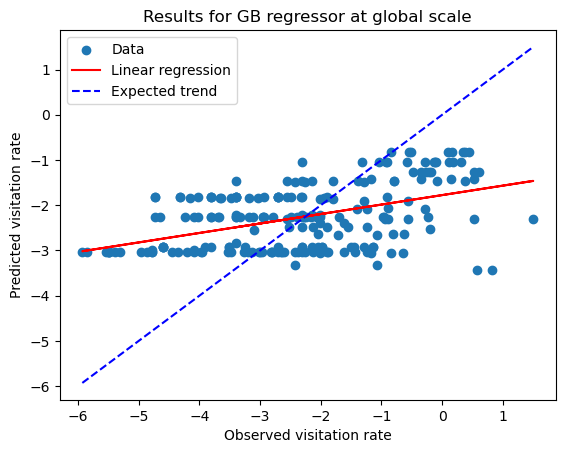

In [53]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for GB regressor at global scale')

# show legend
plt.legend()

# show plot
plt.show()

In [57]:
df_JdA = pd.read_csv('../data/Features_JdA_validation_2019.csv')

# Add biome information
df_JdA['x0_1.0'] = 0.0
df_JdA['x0_2.0'] = 0.0
df_JdA['x0_4.0'] = 0.0
df_JdA['x0_5.0'] = 0.0
df_JdA['x0_7.0'] = 0.0
df_JdA['x0_8.0'] = 0.0
df_JdA['x0_10.0'] = 0.0
df_JdA['x0_12.0'] = 0.0

# Actualizar las celdas de la columna 'x' a 1 si 'biome_num' es igual a 1
df_JdA['x0_1.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 1 else 0)
df_JdA['x0_2.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 2 else 0)
df_JdA['x0_4.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 4 else 0)
df_JdA['x0_5.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 5 else 0)
df_JdA['x0_7.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 7 else 0)
df_JdA['x0_8.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 8 else 0)
df_JdA['x0_10.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 10 else 0)
df_JdA['x0_12.0'] = df_JdA['biome_num'].apply(lambda x: 1 if x == 12 else 0)

df_JdA['moss'] = 0.5*(df_JdA['moss_large'] + df_JdA['moss_small'])
df_JdA['shrub'] =  0.5*(df_JdA['shrub_large'] + df_JdA['shrub_small'])
df_JdA['management'] = 0.0

# Set units in international system (correct scale from GEE)
# scale_bio     = 0.1  # units ºC or mm
# scale_soilC   = 5    # units g/kg
# scale_soilden = 10   # kg/m3
# scale_pdsi    = 0.01 # unitless (Palmer Drought Severity Index)
# df_JdA['bio01'] = df_JdA['bio01'] * scale_bio
# df_JdA['bio02'] = df_JdA['bio02'] * scale_bio
# df_JdA['bio05'] = df_JdA['bio05'] * scale_bio
# df_JdA['bio08'] = df_JdA['bio08'] * scale_bio
# df_JdA['bio14'] = df_JdA['bio14'] * scale_bio
# df_JdA['soil_carbon_b10'] = df_JdA['soil_carbon_b10'] * scale_soilC
# df_JdA['soil_den_b10']    = df_JdA['soil_den_b10']    * scale_soilden
# df_JdA['pdsi']            = df_JdA['pdsi']            * scale_pdsi

In [58]:
selected_columns_JdA = ['study_id','site_id','.geo','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
df_JdA_train = df_JdA[selected_columns_JdA]

# Lista de columnas en las que quieres rellenar los valores faltantes
columnas_a_rellenar = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']

# Rellenar los valores faltantes solo en las columnas especificadas
df_JdA_train[columnas_a_rellenar] = df_JdA_train[columnas_a_rellenar].apply(lambda col: col.fillna(col.mean()))


df_JdA_train_NO_NA = df_JdA_train.dropna()

C:\Users\alfon\AppData\Local\Temp\ipykernel_10928\3263556520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_JdA_train[columnas_a_rellenar] = df_JdA_train[columnas_a_rellenar].apply(lambda col: col.fillna(col.mean()))


In [59]:
# Filtrar las filas con al menos un valor nulo
filas_con_nulos = df_JdA_train[df_JdA_train.isna().any(axis=1)]

# Imprimir las filas con valores nulos
print("Filas con valores nulos:")
print(filas_con_nulos)

Filas con valores nulos:
Empty DataFrame
Columns: [study_id, site_id, .geo, bio01, bio02, bio05, bio08, bio14, ec, elevation, es, gHM, pdsi, soil_den_b10, moss, shrub, management, x0_1.0, x0_2.0, x0_4.0, x0_5.0, x0_7.0, x0_8.0, x0_10.0, x0_12.0]
Index: []

[0 rows x 25 columns]


In [60]:
from sklearn.preprocessing import StandardScaler
# Seleccionar las columnas por nombre
columnas_a_escalar = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']

# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Hay que escalar con las medias y desviaciones estandard de los datos de entrenamiento de CropPol:
df_croppol_train_raw = pd.read_csv('../data/ml_global.csv')

# Crear una clave compuesta en ambos dataframes
df_croppol_train_raw['key'] = df_croppol_train_raw['study_id'].astype(str) + '-' + df_croppol_train_raw['site_id'].astype(str)
df_ML_train_without_na['key'] = df_ML_train_without_na['study_id'].astype(str) + '-' + df_ML_train_without_na['site_id'].astype(str)

# Filtrar df2 basándose en las claves de df1
df_croppol_train = df_croppol_train_raw[df_croppol_train_raw['key'].isin(df_ML_train_without_na['key'])]

medias = df_croppol_train[columnas_a_escalar].mean()
desviaciones = df_croppol_train[columnas_a_escalar].std()

# Ahora escala las columnas en df2 usando las medias y desviaciones de df1
for columna in columnas_a_escalar:

    df_JdA_train_NO_NA[columna] = (df_JdA_train_NO_NA[columna] - medias[columna]) / desviaciones[columna]

# # Escalar las columnas seleccionadas
# df_JdA_train_NO_NA.loc[:, columnas_a_escalar] = scaler.fit_transform(df_JdA_train_NO_NA.loc[:, columnas_a_escalar])

In [61]:
# make predictions
X_test_JdA = df_JdA_train_NO_NA[X_columns]
df_JdA_train_NO_NA['GB'] = best_model.predict(X_test_JdA)

In [62]:
print(best_model.predict(X_test_JdA))

[-3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -2.43881868 -2.8278694  -2.8278694  -3.42575653
 -2.43881868 -2.8278694  -3.42575653 -2.8278694  -3.42575653 -2.8278694
 -2.8278694  -2.8278694  -2.8278694  -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.42575653
 -3.42575653 -3.42575653 -3.42575653 -3.42575653 -3.03670581 -2.62933631
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.03670581
 -3.03670581 -3.03670581 -3.03670581 -3.03670581 -3.

In [63]:
import json
# Convierte la cadena JSON en un diccionario
df_JdA_train_NO_NA['.geo'] = df_JdA_train_NO_NA['.geo'].apply(lambda x: json.loads(x))

# Separa las coordenadas en columnas de latitud y longitud
df_JdA_train_NO_NA[['Longitud', 'Latitud']] = df_JdA_train_NO_NA['.geo'].apply(lambda x: pd.Series(x['coordinates']))

# Elimina la columna original ".geo"
df_JdA_train_NO_NA.drop('.geo', axis=1, inplace=True)

In [64]:
df_JdA_train_NO_NA.to_csv('../data/Features_JdA_validation_2019_pred_GB.csv', index=False)

In [22]:
medias

bio01           133.389873
bio02            95.688608
bio05           261.902532
bio08           160.175949
bio14            41.463291
ec                1.194154
elevation       435.715190
es                0.443810
gHM               0.515380
pdsi            -20.729219
soil_den_b10    128.788608
moss              0.000033
shrub             6.483378
dtype: float64

In [23]:
desviaciones

bio01            58.437643
bio02            22.371996
bio05            42.661391
bio08            66.156481
bio14            27.612667
ec                0.700351
elevation       558.628511
es                0.291493
gHM               0.180232
pdsi            289.181057
soil_den_b10     14.649331
moss              0.000249
shrub             6.123688
dtype: float64